Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/conecomplicado90.stl
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory


number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = -25, model zmax = 100, first plane Z = -26.996, number of planes = 65
-Incremental, conecomplicado90.stl, thickness = 2, #T = 1140, #P = 63, #S = 11177, 0.001736s (slicing), 0.015941s (polygon assembling), 0.080514s (total), *K: 9.80439


writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing image: ../input/sliced/layer_010.pgm


writing image: ../input/sliced/layer_011.pgm


writing image: ../input/sliced/layer_012.pgm


writing image: ../input/sliced/layer_

Paredes Finas

In [3]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 2.963104724884033
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0010216236114501953
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.03534102439880371
Total de [Fase 1: Camada: 0] : 3.0257580280303955
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 3.5455329418182373
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.00140380859375
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.026137351989746094
Total de [Fase 1: Camada: 1] : 3.5888876914978027
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 3.8574769496917725
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0018115043640136719
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.04434776306152344
Total de [Fase 1: Camada: 2] : 3.93332052

Contornos

In [4]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 0.8732054233551025
Criando os loops
Total de [Criando os loops] : 0.4078705310821533
Criando regiões de influência
Total de [Criando regiões de influência] : 0.040039777755737305
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 0.12625789642333984
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:19 maior void:0.002509410288582183Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:0Bw -> bloqueado por limite maximo
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 0] Perdendo total:0Bw -> bloqueado por limite maximo
Total de [Retirando regiões da camada] : 0.42114758491516113
Reunindo todos os loops em uma unica imagem
Total de [Reunindo todos os loops em uma unica imagem] : 0.035881757736206055
salvando imagens das regiões
deletado: /L_000/I_000/offsets
Total de [salvando imagens das regiões] : 0.18425297737121582
Total de [Fase 2: Camada: 0] : 2

Pontes

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.0433695316314697
Criando pontes de Zigzag
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 7.670783519744873
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Total de [Criando pontes de Crossover] : 0.036316871643066406
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.022749900817871094
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.0004887580871582031
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.171281099319458
Total de [Fase 3: Camada: 0] : 9.001193523406982
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 1.0296010971069336
Criando pontes de Zigzag
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 7.4757421016693115
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Total de [Criando pontes de Crossover] : 0.04190254211425781
Ret

Zigzags

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.8305761814117432
salvando imagens das regiões
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das regiões] : 0.008358955383300781
Total de [Fase 4: Camada: 0] : 0.9438223838806152
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.8250200748443604
salvando imagens das regiões
deletado: /L_001/I_000/zigzags
Total de [salvando imagens das regiões] : 0.005063295364379883
Total de [Fase 4: Camada: 1] : 0.909552812576294
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.7213866710662842
salvando imagens das regiões
deletado: /L_002/I_000/zigzags
Total de [salvando imagens das regiões] : 0.008115291595458984
Total de [Fase 4: Camada: 2] : 1.8144023418426514
Fase 4: Camada: 3
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 0.8502230644226074
salvando imagens das regiões
deletado: /L_

iMAGEM DO MAPEAMENTO

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.6342771053314209
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.298870325088501
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.30405116081237793
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.4098634719848633
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.2905559539794922
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.3055088520050049
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.2988309860229492
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.29848670959472656
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.3027462959289551
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.34121131896972656
Fase 4: Camada: 10


Total de [Fase 4: Camada: 10] : 0.33567357063293457
Fase 4: Camada: 11


Total de [Fase 4: Camada: 11] : 0.2982027530670166
Fase 4: Camada: 12


Total de [Fase 4: Camada: 12] : 0.32183313369750977
Fase 4: Camada: 13


Total de [Fase 4: Camada: 13] : 0.3109285831451416
Fase 4: 

/tmp/ipykernel_28288/2909573810.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()




Total de [Fase 4: Camada: 20] : 0.3273744583129883
Fase 4: Camada: 21


Total de [Fase 4: Camada: 21] : 0.3093531131744385
Fase 4: Camada: 22


Total de [Fase 4: Camada: 22] : 0.30118823051452637
Fase 4: Camada: 23


Total de [Fase 4: Camada: 23] : 0.3196260929107666
Fase 4: Camada: 24


Total de [Fase 4: Camada: 24] : 0.29146528244018555
Fase 4: Camada: 25


Total de [Fase 4: Camada: 25] : 0.4543306827545166
Fase 4: Camada: 26


Total de [Fase 4: Camada: 26] : 0.3024768829345703
Fase 4: Camada: 27


Total de [Fase 4: Camada: 27] : 0.2984905242919922
Fase 4: Camada: 28


Total de [Fase 4: Camada: 28] : 0.31232285499572754
Fase 4: Camada: 29


Total de [Fase 4: Camada: 29] : 0.29668545722961426
Fase 4: Camada: 30


Total de [Fase 4: Camada: 30] : 0.29462289810180664
Fase 4: Camada: 31


Total de [Fase 4: Camada: 31] : 0.2971475124359131
Fase 4: Camada: 32


Total de [Fase 4: Camada: 32] : 0.2882373332977295
Fase 4: Camada: 33


Total de [Fase 4: Camada: 33] : 0.2800452709197998
Fase 4

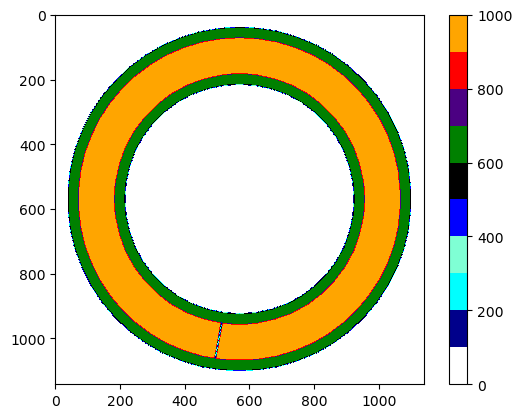

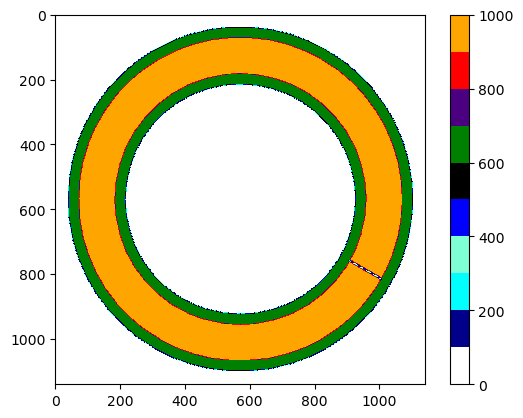

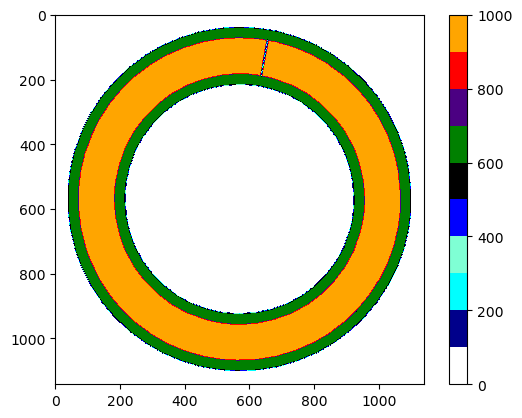

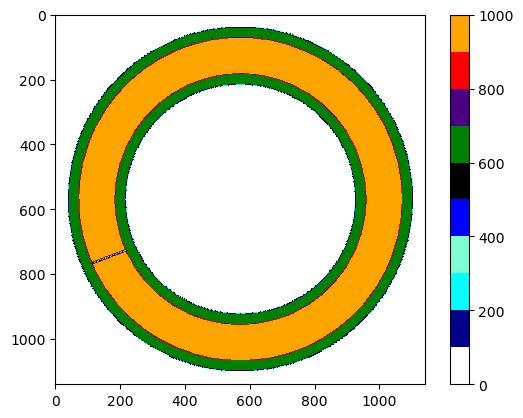

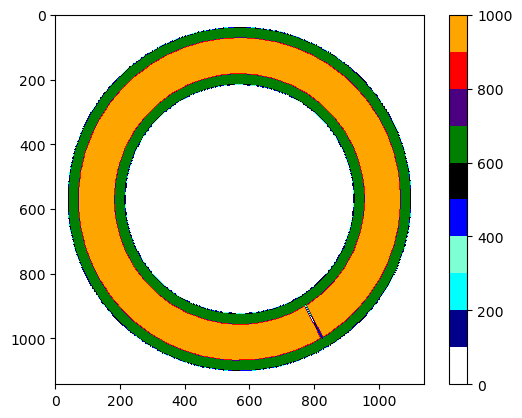

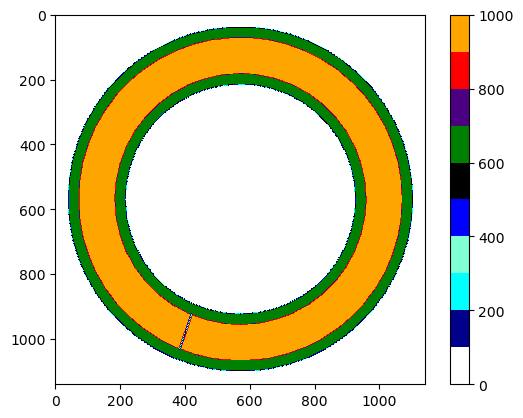

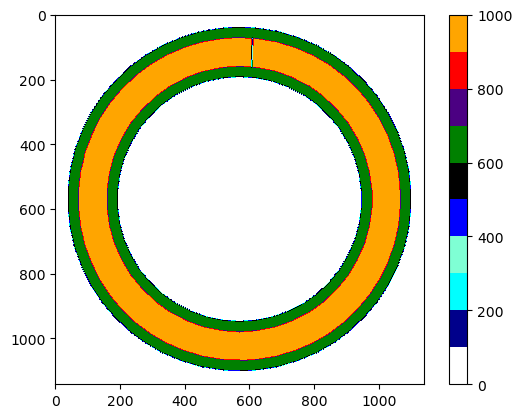

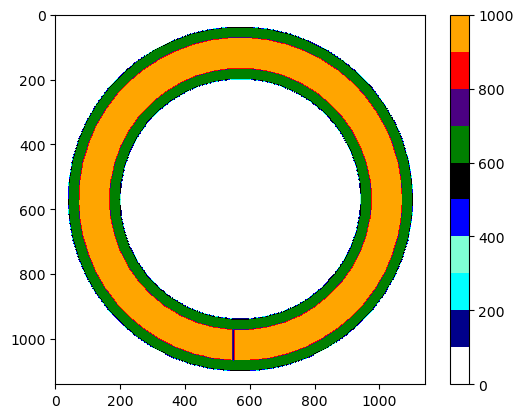

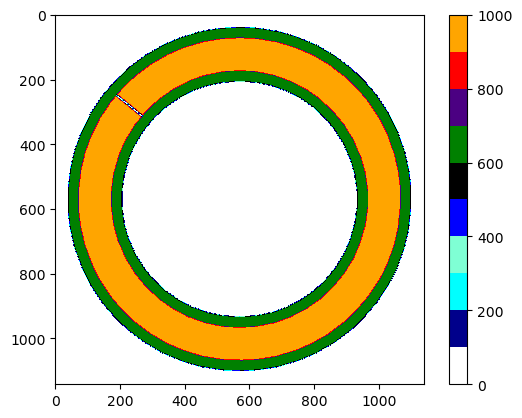

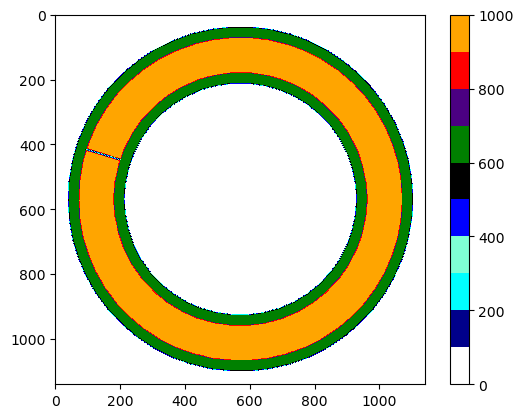

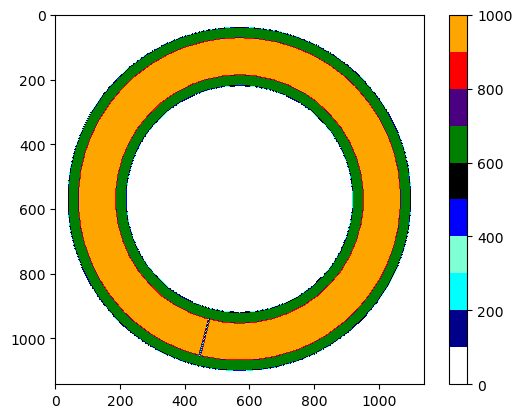

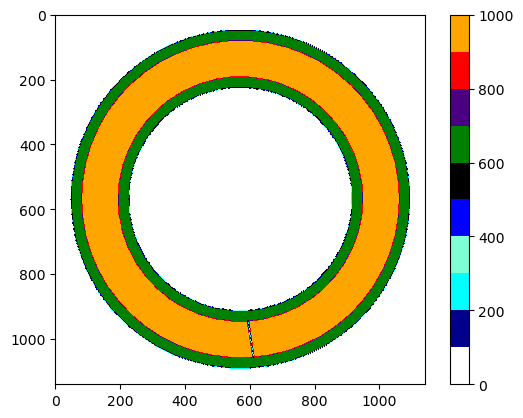

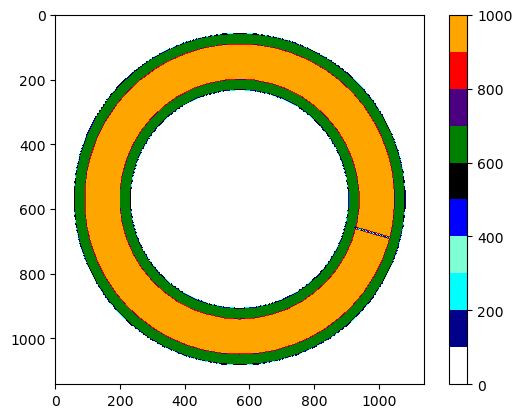

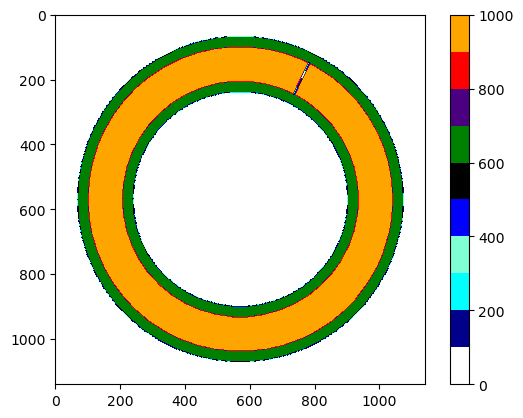

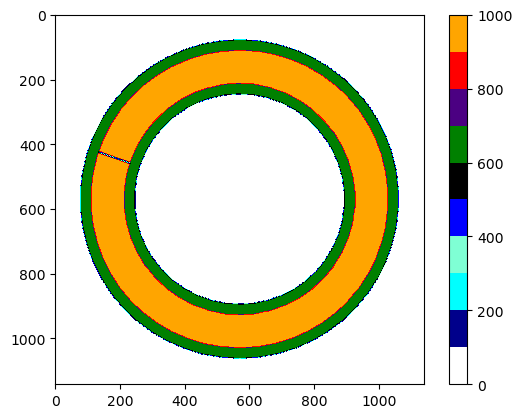

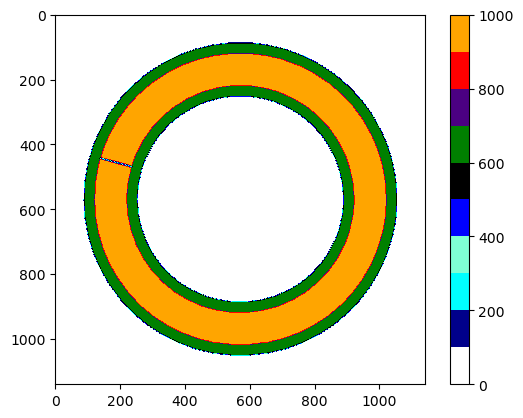

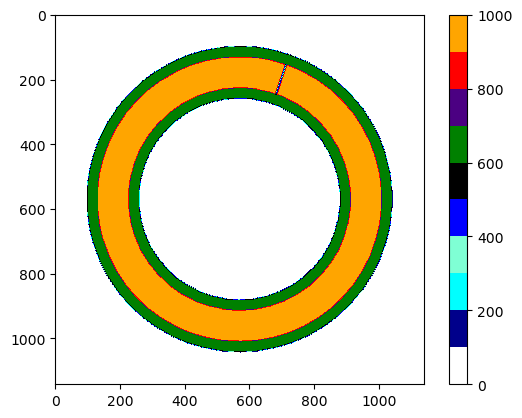

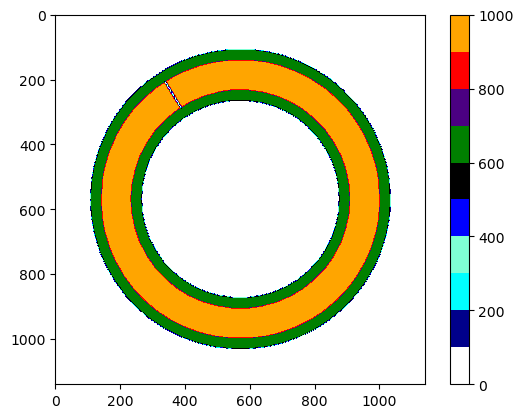

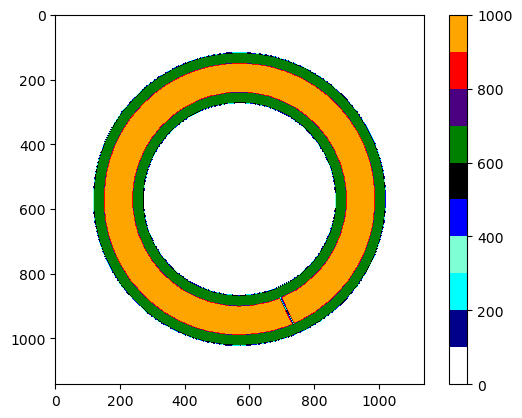

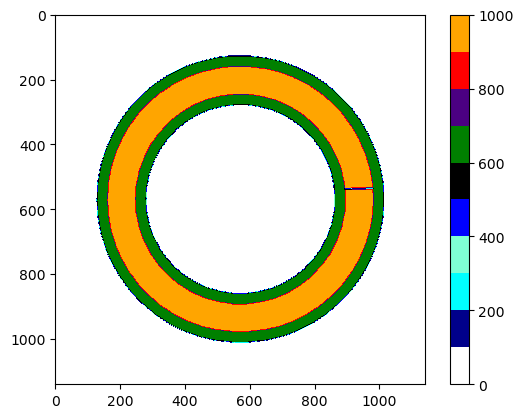

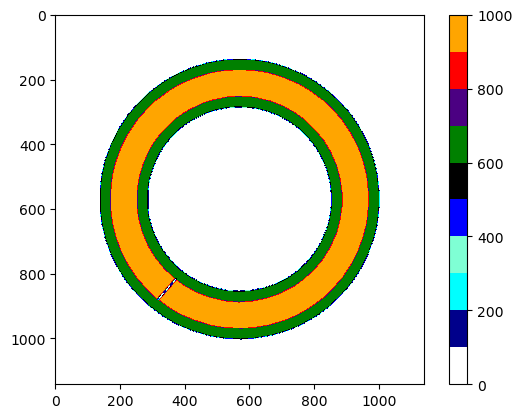

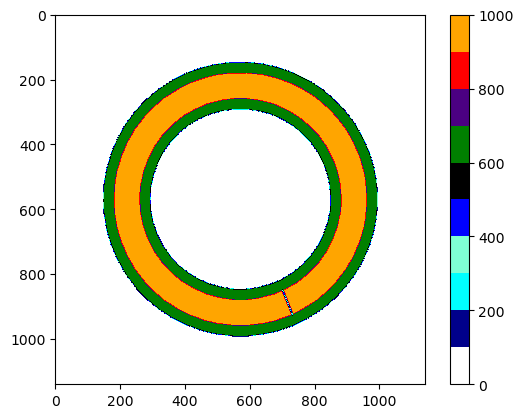

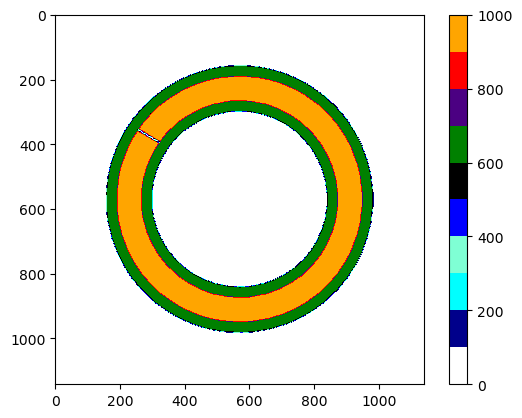

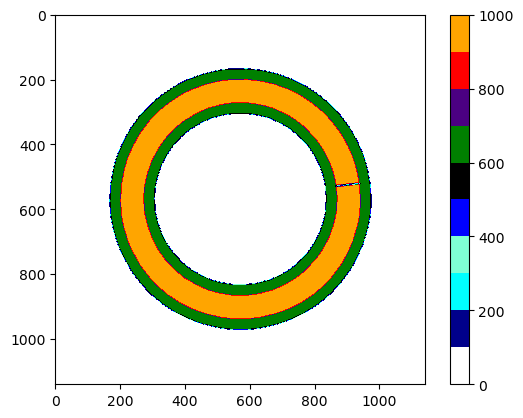

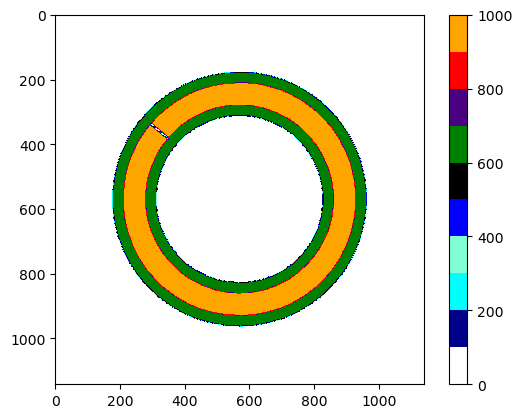

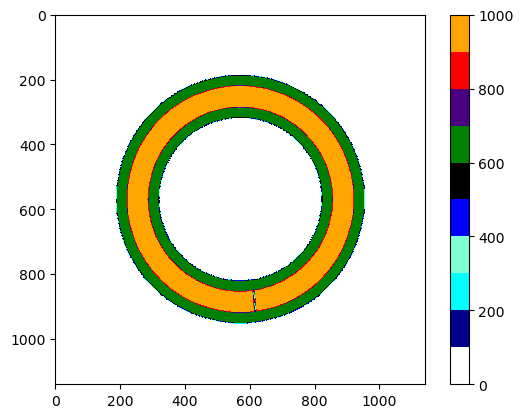

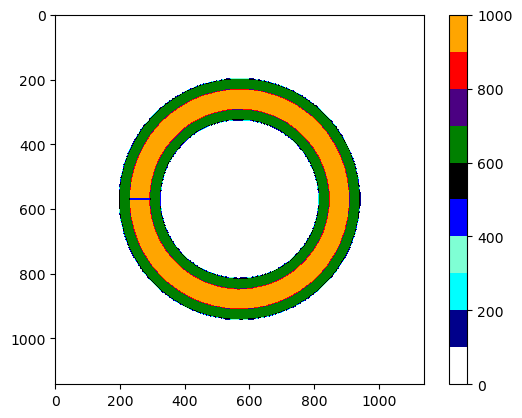

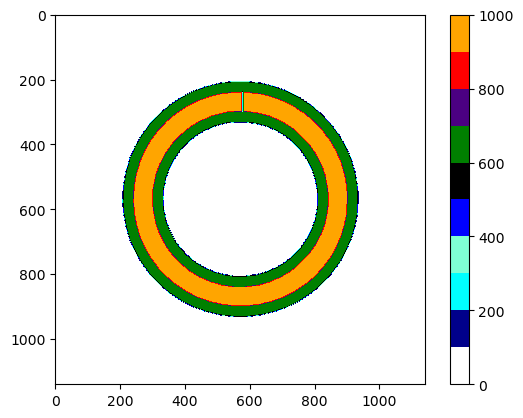

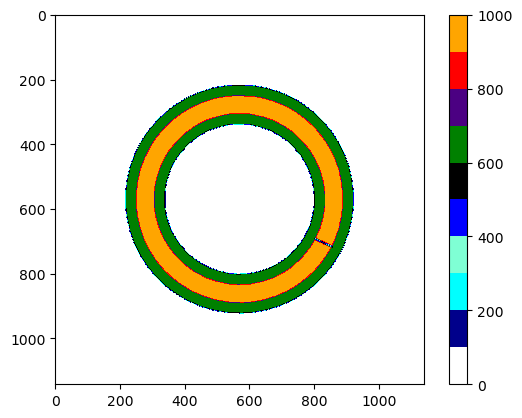

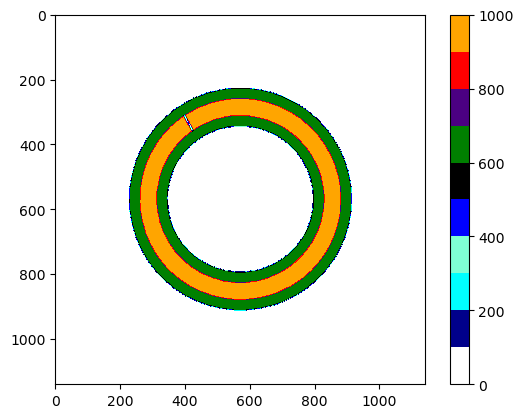

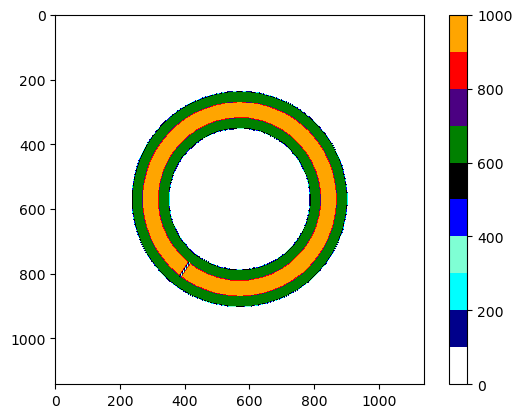

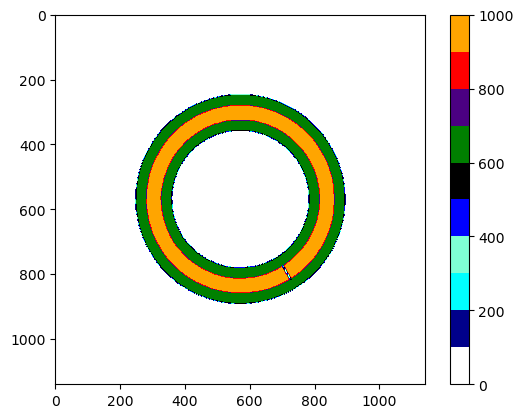

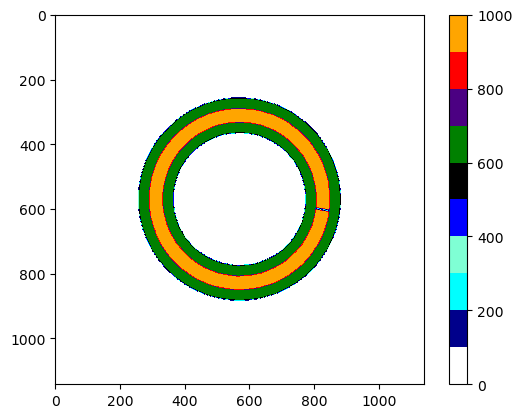

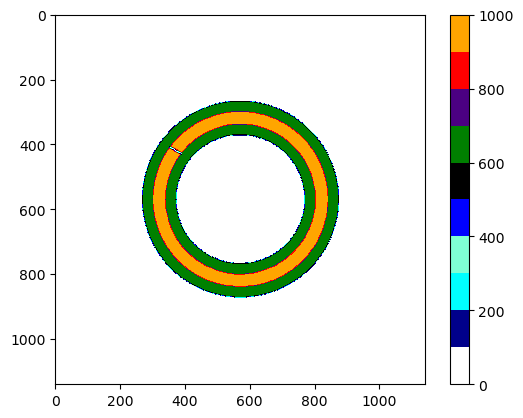

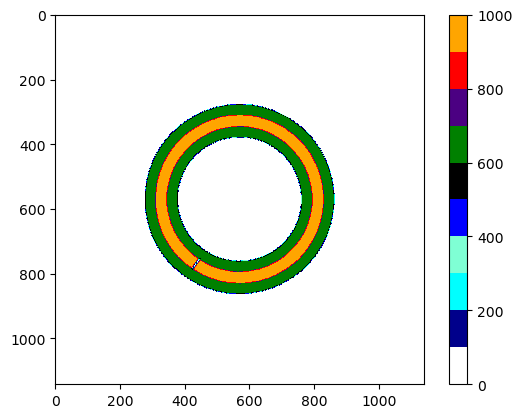

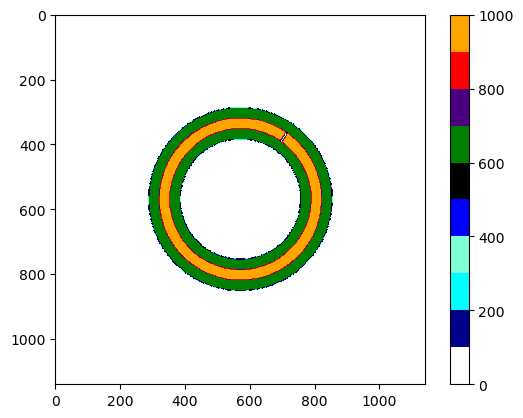

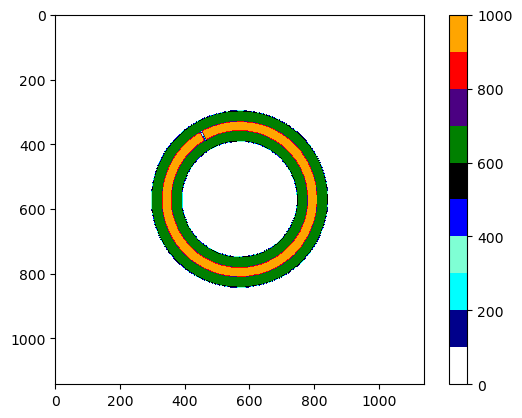

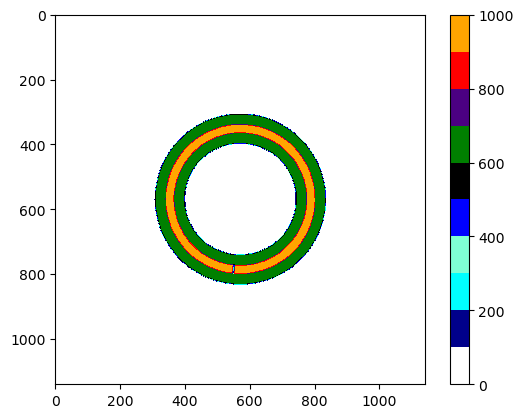

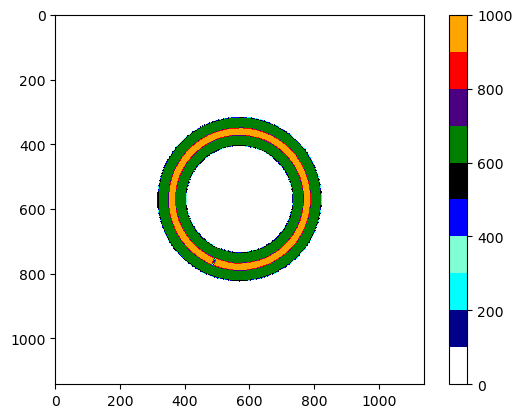

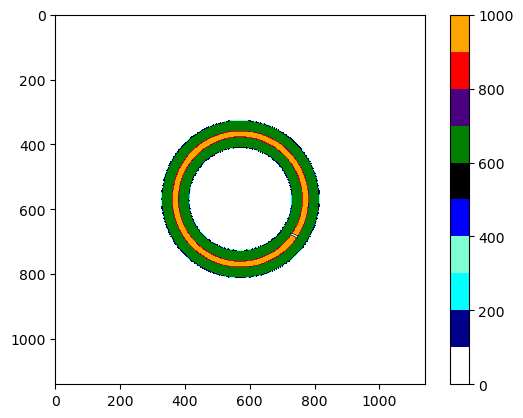

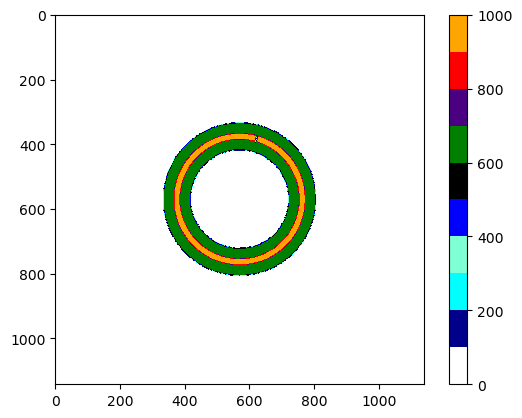

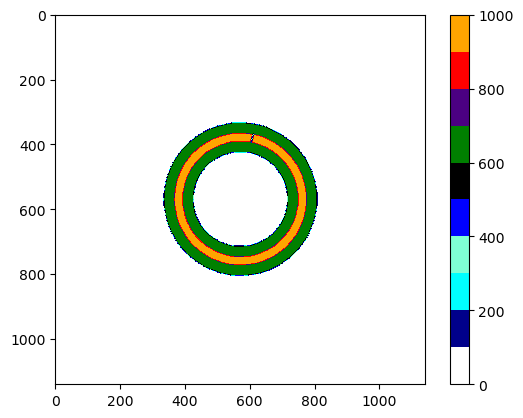

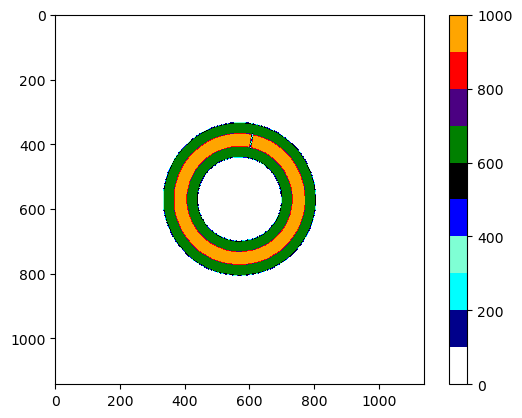

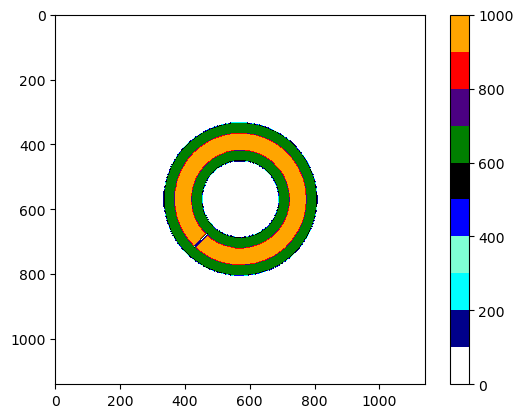

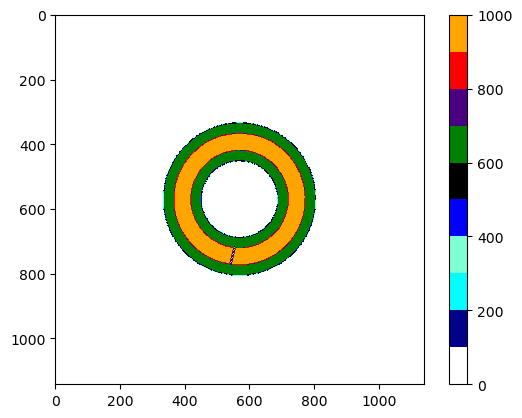

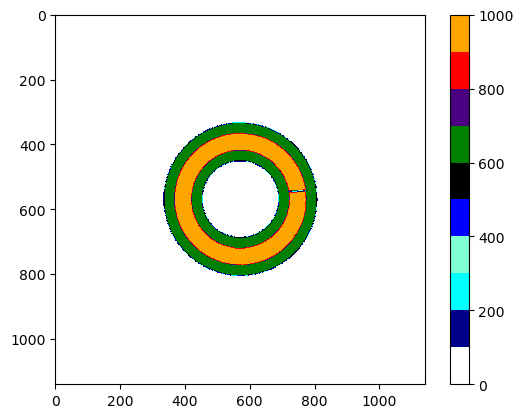

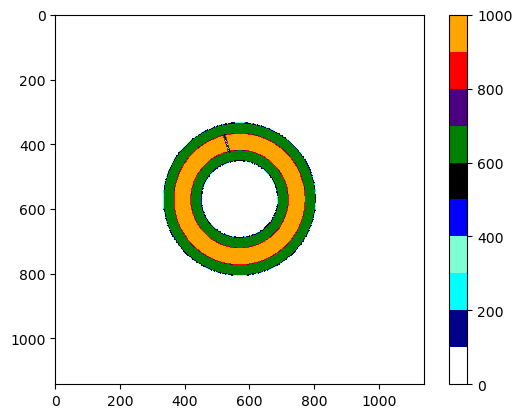

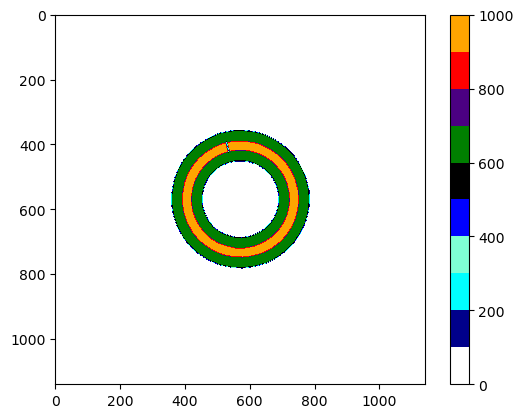

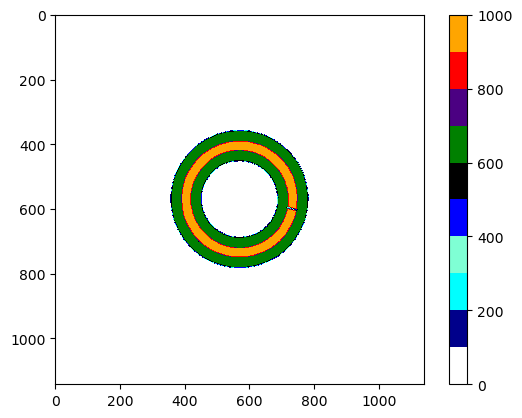

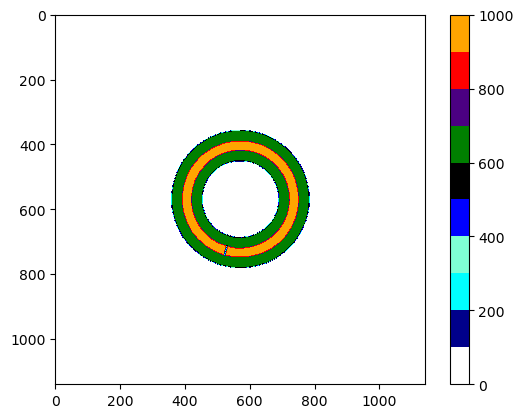

In [ ]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        # if i%2 == 1:
        #     img_mapping = it.rotate_img_ccw(img_mapping )
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09822988510131836
Total de [Making offset routes] : 2.26578426361084
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.09615182876586914
Total de [Making offset routes] : 2.3217883110046387
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.12299680709838867
Total de [Making offset routes] : 2.2749719619750977
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0936434268951416
Total de [Making offset routes] : 2.607133388519287
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.10295414924621582
Total de [Making offset routes] : 2.638007164001465
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.12091970443725586
Total de [Making offset routes] : 2.288832664489746
Making offset routes
salvando imagens da

Rotas de pontes

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
with Timer(f"Making bridges routes"):
    for c in camadas:
        with Timer(f"Camada: {c.name}"):
            c.make_bridges_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
Camada: L_000
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.0002448558807373047
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 5.125999450683594e-05
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 17.721051692962646
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.22904181480407715
Total de [Camada: L_000] : 18.382625579833984
Camada: L_001
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.0009589195251464844
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 0.00021719932556152344
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 17.64917278289795
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.21272778511047363
Total de [Camada: L_001] : 18.257102966308594
Camada: L_002
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.0006968975067138672
Making Zigzag

Rotas de Ziguezague

In [ ]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 11.581408262252808
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.5842983722686768
Total de [criando as rotas de zigzag, camada:L_000] : 13.7742018699646
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.06543803215026855
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.00703120231628418
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.0033257007598876953
salvando grafos
Total de [salvando grafos] : 0.12356352806091309
Total de [Making zigzag routes] : 14.305460929870605
Making zigzag routes
criando as rotas de zigzag, camada:L_001
fazendo as tres opções:
Total de [fazendo as tres opções:] : 11.691110134124756
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4302067756652832
Total de [criando as rotas de zigzag, camada:L_001] : 13.338494300842

WEAVING

In [ ]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 3.7473864555358887
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.25501108169555664
Total de [Fase 5 b] : 4.0085930824279785
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 4.622244358062744
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.25040626525878906
Total de [Fase 5 b] : 4.875332593917847
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 4.152703762054443
salvando rotas
deletado: /L_002/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.18548178672790527
Total de [Fase 5 b] : 4.339316368103027
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 4.394259452819824
salvando rotas
deletado: /L_003/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.15641427040100098
Total 

Rotas de Thin Walls

In [ ]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.09372210502624512
salvando imagens das rotas
Total de [salvando imagens das rotas] : 5.0067901611328125e-05
Total de [Making thin walls routes] : 0.0948946475982666
Total de [Fase 5] : 0.09519672393798828
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.08264565467834473
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.000148773193359375
Total de [Making thin walls routes] : 0.08631396293640137
Total de [Fase 5] : 0.0867452621459961
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.09923839569091797
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.437301635742188e-05
Total de [Making thin walls routes] : 0.10097861289978027
Total de [Fase 5] : 0.10120654106140137
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.0814368724822998
salvando imagens das rotas
Total de [salvando 

Encontrando o lugar onde será o começo da trilha de cada ilha

In [ ]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.islands_path_starts(folders)

%reset_selective -f "camadas"                        

Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.002965688705444336
Total de [Encontrando ponto de união ext-int] : 0.7870285511016846
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.003771066665649414
Total de [Encontrando ponto de união ext-int] : 0.7626776695251465
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.006612300872802734
Total de [Encontrando ponto de união ext-int] : 0.8168637752532959
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.002430438995361328
Total de [Encontrando ponto de união ext-int] : 0.7453854084014893
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0022454261779785156
Total de [Encontrando ponto de união ext-int] : 0.6652665138244629
Encontrando ponto de união ext-int
salvando image

Unificando rotas EXTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.5393261909484863
Conectando pontes de Crossover
salto:  [667, 609]
salto:  [1080, 319]
Total de [Conectando pontes de Crossover] : 3.280834436416626
Total de [Conectando rotas externas] : 4.274498462677002
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.41577672958374023
Total de [Fase 6] : 4.691218614578247
Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.6123771667480469
Conectando pontes de Crossover
salto:  [319, 686]
salto:  [607, 1096]
Total de [Conectando pontes de Crossover] : 3.3029446601867676
Total de [Conectando rotas externas] : 4.354911804199219
salvando imagens das rotas
deletado: /L_001/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.4103679656982422
Total de [Fase 6] : 4.767364978790283
Fase 6
Conectando rotas externas
Conectando 

Unificando rotas INTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 2.2492928504943848
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.004545927047729492
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.19417977333068848
Total de [Fase 7] : 2.9123966693878174
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 1.927527666091919
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0030384063720703125
salvando imagens das rotas
deletado: /L_001/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.2032012939453125
Total de [Fase 7] : 2.5547218322753906
Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 3.5734453201293945
Conectando pontes de zigzag
Total de [Conectando pontes de zigzag] : 0.0030324459075927734
salvando imagens das rotas
deletado: /L_002/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.2

Unindo rotas de thin walls

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0011527538299560547
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.124786376953125
Total de [Fase 8] : 0.18094944953918457
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.001331329345703125
salvando imagens das rotas
deletado: /L_001/I_000/thinwalls_tree_route/sequence
deletado: /L_001/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.1195836067199707
Total de [Fase 8] : 0.16559123992919922
Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0028069019317626953
salvando imagens das rotas
deletado: /L_002/I_000/thinwalls_tree_route/sequence
deletado: /L_002/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.1415250301361084
Total de [Fase 8] : 0.19551897048950195
Fase 8
Convertendo paredes fin

Unindo todas as rotas

In [ ]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.225968599319458
Conectando todas as partes
Total de [Conectando todas as partes] : 0.04909229278564453
salvando imagens das rotas
deletado: /L_000/I_000/island_route
[[830, 849], [445, 849], [444, 848], [427, 848], [426, 847], [392, 846], [391, 845], [386, 845], [385, 844], [381, 844], [380, 843], [376, 843], [375, 842], [371, 842], [370, 841], [366, 841], [365, 840], [360, 840], [359, 839], [345, 837], [344, 836], [336, 834], [333, 832], [325, 830], [323, 828], [317, 827], [316, 826], [311, 825], [308, 823], [300, 821], [248, 795], [207, 767], [180, 742], [179, 742], [165, 728], [165, 727], [159, 721], [159, 720], [153, 714], [153, 713], [147, 707], [147, 706], [141, 700], [141, 699], [134, 691], [124, 676], [123, 673], [109, 653], [97, 629], [97, 627], [86, 606], [86, 604], [85, 603], [85, 601], [84, 600], [84, 598], [83, 597], [83, 595], [82, 594], [82, 592], [81, 591], [81, 589], [80, 588], [80, 58

Gerando o Código G

In [ ]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [20+8+2+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
nome: L_000/I_000
[[830, 849], [445, 849], [444, 848], [427, 848], [426, 847], [392, 846], [391, 845], [386, 845], [385, 844], [381, 844], [380, 843], [376, 843], [375, 842], [371, 842], [370, 841], [366, 841], [365, 840], [360, 840], [359, 839], [345, 837], [344, 836], [336, 834], [333, 832], [325, 830], [323, 828], [317, 827], [316, 826], [311, 825], [308, 823], [300, 821], [248, 795], [207, 767], [180, 742], [179, 742], [165, 728], [165, 727], [159, 721], [159, 720], [153, 714], [153, 713], [147, 707], [147, 706], [141, 700], [141, 699], [134, 691], [124, 676], [123, 673], [109, 653], [97, 629], [97, 627], [86, 606], [86, 604], [85, 603], [85, 601], [84, 600], [84, 598], [83, 597], [83, 595], [82, 594], [82, 592], [81, 591], [81, 589], [80, 588], [80, 586], [79, 585], [79, 583], [78, 582], [78, 580], [77, 579], [77, 577], [76, 576], [76, 574], [75, 573], [75, 571], [74, 570], [74, 568], [70, 558], [70, 555], [69, 554], [69, 550], [68, 549], [68, 545], [67, 544], [67

In [ ]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [ ]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [ ]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [ ]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)